Hodgkin-Huxley simulation (following Dayna & Abbott Ch 5). (Note: for Python at least, we need a simulation timestep of 0.01 ms since 0.1 ms causes numerical errors that make the result explode).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np


def set_font_size(ax, font_size, legend_font_size=None):
    """Set fontsize of all axis text objects to specified value."""

    texts = ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels())

    for text in texts:
        text.set_fontsize(font_size)

    if legend_font_size is None:
        legend_font_size = font_size

    legend = ax.get_legend()

    if legend:
        for text in legend.get_texts():
            text.set_fontsize(legend_font_size)


def get_n_vars(v):
    
    a_n = .01 * (v + 55) / (1 - np.exp(-.1*(v + 55)))
    b_n = .125 * np.exp(-0.0125*(v + 65))
    
    tau_n_ = 1/(a_n + b_n)
    n_inf_ = a_n/(a_n + b_n)
    
    return tau_n_, n_inf_

def get_m_vars(v):
    
    a_m = .1 * (v + 40) / (1 - np.exp(-.1*(v + 40)))
    b_m = 4*np.exp(-0.0556*(v + 65))
    
    tau_m_ = 1/(a_m + b_m)
    m_inf_ = a_m/(a_m + b_m)
    
    return tau_m_, m_inf_

def get_h_vars(v):
    
    a_h = 0.07*np.exp(-0.05*(v + 65))
    b_h = 1/(1 + np.exp(-0.1*(v + 35)))
    
    tau_h_ = 1/(a_h + b_h)
    h_inf_ = a_h/(a_h + b_h)
    
    return tau_h_, h_inf_

/home/melete/miniconda3/envs/py3/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


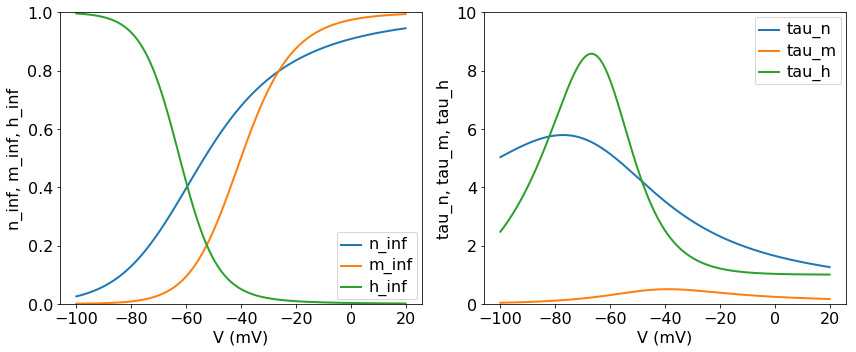

In [2]:
# plot voltage dependence of inf and tau vars
v = np.linspace(-100, 20, 500)

tau_n, n_inf = get_n_vars(v)
tau_m, m_inf = get_m_vars(v)
tau_h, h_inf = get_h_vars(v)

fig, axs = plt.subplots(1, 2, figsize=(12, 5), tight_layout=True)

# inf vars
axs[0].plot(v, n_inf, lw=2)
axs[0].plot(v, m_inf, lw=2)
axs[0].plot(v, h_inf, lw=2)
axs[0].set_ylim(0, 1)

axs[0].set_xlabel('V (mV)')
axs[0].set_ylabel('n_inf, m_inf, h_inf')
axs[0].legend(['n_inf', 'm_inf', 'h_inf'])

# tau vars
axs[1].plot(v, tau_n, lw=2)
axs[1].plot(v, tau_m, lw=2)
axs[1].plot(v, tau_h, lw=2)
axs[1].set_ylim(0, 10)

axs[1].set_xlabel('V (mV)')
axs[1].set_ylabel('tau_n, tau_m, tau_h')
axs[1].legend(['tau_n', 'tau_m', 'tau_h'])

for ax in axs:
    set_font_size(ax, 16)

/home/melete/miniconda3/envs/py3/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


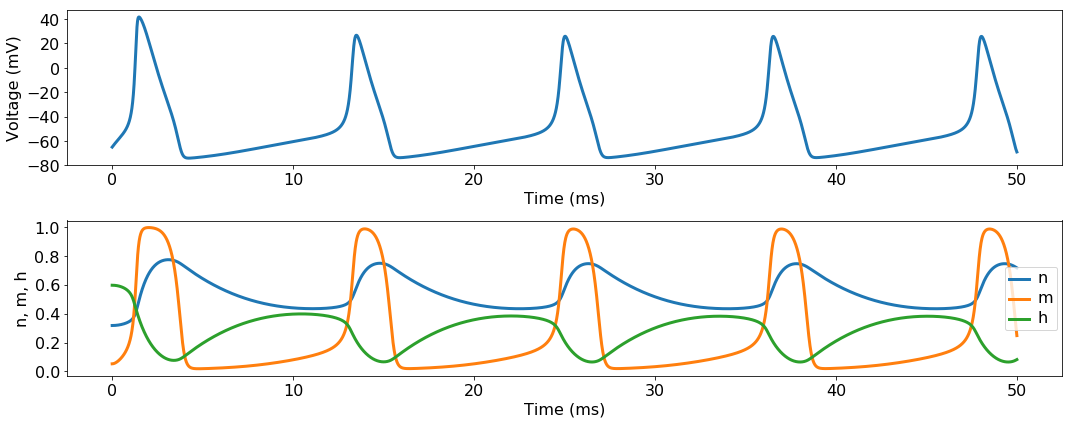

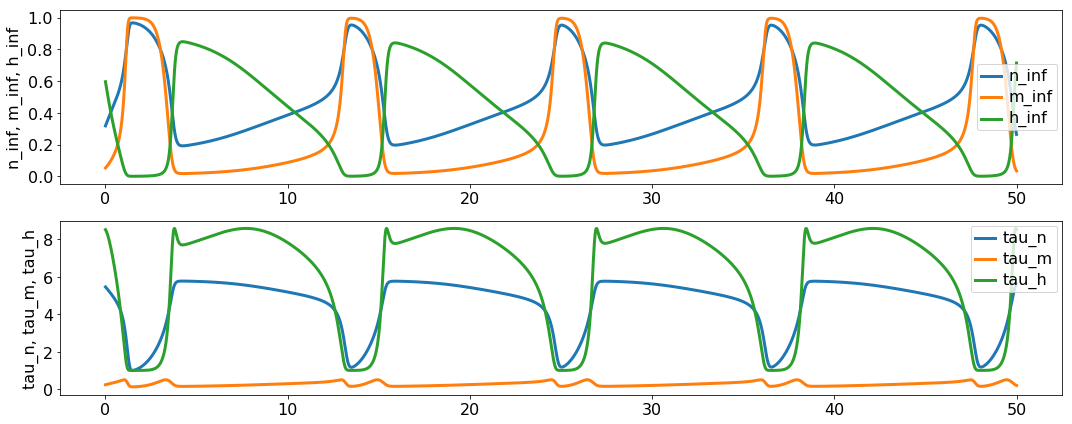

In [3]:
c_m = .01  # uF/mm^2
v_0 = -65  # mV
m_0 = 0.0529
h_0 = 0.5961
n_0 = 0.3177

g_l = 0.003  # mS/mm^2
g_k = 0.36  # mS/mm^2
g_na = 1.2  # mS/mm^2
e_l = -54.387  # mV
e_k = -77  # mV
e_na = 50  # mV
dt = 0.01  # ms (note: 0.1 ms yields pathological numerical errors!)

i_e_a = .2  # uA/mm^2

T = 50  # ms

t = np.arange(0, T, dt)  # time vector (ms)

v = np.nan * np.zeros(len(t))
n = np.nan * np.zeros(len(t))
m = np.nan * np.zeros(len(t))
h = np.nan * np.zeros(len(t))

tau_n = np.nan * np.zeros(len(t))
n_inf = np.nan * np.zeros(len(t))
tau_m = np.nan * np.zeros(len(t))
m_inf = np.nan * np.zeros(len(t))
tau_h = np.nan * np.zeros(len(t))
h_inf = np.nan * np.zeros(len(t))

v[0] = v_0
n[0] = n_0
m[0] = m_0
h[0] = h_0

# run simulation
for t_idx in range(1, len(t)):
    
    # get prev v, n, m, and h
    v_ = v[t_idx-1]
    n_ = n[t_idx-1]
    m_ = m[t_idx-1]
    h_ = h[t_idx-1]
    
    # get tau and inf vars as func of voltage
    tau_n_, n_inf_ = get_n_vars(v_)
    tau_m_, m_inf_ = get_m_vars(v_)
    tau_h_, h_inf_ = get_h_vars(v_)
    
    # store tau and inf vars
    tau_n[t_idx] = tau_n_
    n_inf[t_idx] = n_inf_
    tau_m[t_idx] = tau_m_
    m_inf[t_idx] = m_inf_
    tau_h[t_idx] = tau_h_
    h_inf[t_idx] = h_inf_
    
    # update n, m, and h
    n[t_idx] = n_ + (dt/tau_n_) * (n_inf_ - n_)
    m[t_idx] = m_ + (dt/tau_m_) * (m_inf_ - m_)
    h[t_idx] = h_ + (dt/tau_h_) * (h_inf_ - h_)
    
    # get membrane current
    i_m = g_l*(v_ - e_l) + g_k*(n[t_idx]**4)*(v_ - e_k) + g_na*(m[t_idx]**3)*h[t_idx]*(v_ - e_na)
    
    # update voltage
    v[t_idx] = v_ + (dt/c_m)*(-i_m + i_e_a)


# plot primary dynamical variables
fig, axs = plt.subplots(2, 1, figsize=(15, 6), tight_layout=True)
axs[0].plot(t, v, lw=3)
axs[0].set_ylabel('Voltage (mV)')
axs[1].plot(t, n, lw=3)
axs[1].plot(t, m, lw=3)
axs[1].plot(t, h, lw=3)
axs[1].set_ylabel('n, m, h')
axs[1].legend(['n', 'm', 'h'])

for ax in axs:
    ax.set_xlabel('Time (ms)')
    set_font_size(ax, 16)
    
# plot auxiliary variables
fig, axs = plt.subplots(2, 1, figsize=(15, 6), tight_layout=True)
axs[0].plot(t, n_inf, lw=3)
axs[0].plot(t, m_inf, lw=3)
axs[0].plot(t, h_inf, lw=3)
axs[0].set_ylabel('n_inf, m_inf, h_inf')
axs[0].legend(['n_inf', 'm_inf', 'h_inf'])

axs[1].plot(t, tau_n, lw=3)
axs[1].plot(t, tau_m, lw=3)
axs[1].plot(t, tau_h, lw=3)
axs[1].set_ylabel('tau_n, tau_m, tau_h')
axs[1].legend(['tau_n', 'tau_m', 'tau_h'])

for ax in axs:
    set_font_size(ax, 16)